In [1]:
import os
import numpy as np
import scipy.io as sio
import openslide

import argparse
import pandas as pd
import scanpy as sc
from scipy.sparse import issparse
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from PIL import Image
import random
import h5py
import cv2

from st_helper import *

import config as CFG
from dataset import CLIPDataset
from models import CLIPModel
# from utils import AvgMeter, get_lr

Image.MAX_IMAGE_PIXELS = 933120000
# sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 0 #3

Rotate the image

In [8]:
spatial_coord_path = '../data/lymph_23/st_files/GSM5924042_frozen_a_1/spatial/tissue_positions_list.csv'
spatial = pd.read_csv(spatial_coord_path, sep="," , na_filter=False, index_col=0, header=None)
spatial.columns = ['in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']

# make two new columns for the x and y coordinates in microns (um)
# spatial['coord_um_x'] = 0
# spatial['coord_um_y'] = 0
spatial

in_tissue  array_row  array_col  pxl_row_in_fullres  \
0                                                                         
ACGCCTGACACGCGCT-1          0          0          0               16718   
TACCGATCCAACACTT-1          0          1          1               16608   
ATTAAAGCGGACGAGC-1          0          0          2               16499   
GATAAGGGACGATTAG-1          0          1          3               16390   
GTGCAAATCACCAATA-1          0          0          4               16281   
...                       ...        ...        ...                 ...   
GAACGTTTGTATCCAC-1          0         77        123                3240   
ATTGAATTCCCTGTAG-1          0         76        124                3132   
TACCTCACCAATTGTA-1          0         77        125                3022   
AGTCGAATTAGCGTAA-1          0         76        126                2913   
TTGAAGTGCATCTACA-1          0         77        127                2803   

                    pxl_col_in_fullres  coord_um_x  coord_um_y  
0                                                               
ACGCCTGACACGCGCT-1                2813           0           0  
TACCGATCCAACACTT-1                3003           0           0  
ATTAAAGCGGACGAGC-1                2813           0           0  
GATAAGGGACGATTAG-1                3003           0           0  
GTGCAAATCACCAATA-1                2812           0           0  
...                                ...         ...         ...  
GAACGTTTGTATCCAC-1               17417           0           0  
ATTGAATTCCCTGTAG-1               17226           0           0  
TACCTCACCAATTGTA-1               17416           0           0  
AGTCGAATTAGCGTAA-1               17226           0           0  
TTGAAGTGCATCTACA-1               17415           0           0  

[4992 rows x 7 columns]

In [14]:
spatial['array_col'].dtype

dtype('int64')

In [3]:
# generate a list of even number until 128 using numpy
even_rows = np.arange(0, 78, 2)
odd_rows = np.arange(1, 78, 2)
even_cols = np.arange(0, 128, 2)
odd_cols = np.arange(1, 128, 2)
print(even_rows)
print(odd_rows)
print(even_cols)
print(odd_cols)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47
 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77]
[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126]
[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127]


In [32]:
def generate_correct_pixel_coordinates(origin_even, even_calibrate_spot, odd_calibrate_spot, res_width, res_height, spatial):
    """
    This function will generate the correct pixel coordinates w.r.t the H&E image rotated 90 degrees clockwise, 
    for each ST spot using two calibration spots and the first spot (at upper left corner: row 0, col 0)
    Because the image might be a bit tilted, we will use two calibration spots to help adjust the step (spot-spot center-to-center distance)

    1. First we will calculate the horizontal and vertical distance between even spots/odd spots
    3. Then we will calculate the x and y coordinates (in microns um) for each spot in the spatial dataframe
    4. Then we will convert the x and y coordinates to pixel coordinates using the resolution (usuallly 0.45um/pixel)
    5. Finally we will make the x and y coordinates integers

    origin_even: tuple, the x and y micron (um) coordinates of the origin for even spots (even row number, even col number)
    even_calibrate_spot: tuple, the x and y coordinates of the spot at the bottom right for even spots
    odd_calibrate_spot: tuple, the x and y coordinates of the spot at the bottom right for odd spots
    resolution: float, usually 0.45um/pixel
    spatial: dataframe, the spatial dataframe with the following columns: in_tissue, array_row, array_col, pxl_row_in_fullres, pxl_col_in_fullres
    
    # origin_even --------------------> x+++
    # |
    # |
    # |
    # |
    # |
    # y+++

    return: dataframe, the spatial dataframe with the following columns: 
            in_tissue, array_row, array_col, pxl_row_in_fullres, pxl_col_in_fullres, 
            coord_um_x, coord_um_y, 
            coord_pixel_x, coord_pixel_y (refer to the image rotated by 90 degrees clockwise)  
     """

    n_spots = 0
    spatial = spatial.copy()
    # make two new columns for the x and y coordinates in microns (um)
    spatial['coord_um_x'] = 0
    spatial['coord_um_y'] = 0
    even_rows = np.arange(0, 78, 2)
    odd_rows = np.arange(1, 78, 2)
    even_cols = np.arange(0, 128, 2)
    odd_cols = np.arange(1, 128, 2)
    horizontal_step = (even_calibrate_spot[0] - origin_even[0]) / (64-1)
    vertical_step = (even_calibrate_spot[1] - origin_even[1])/ (39-1)
    print(f'For even spots: horizontal_step: {horizontal_step}, vertical_step: {vertical_step}')

    x , y = int(origin_even[0]) , int(origin_even[1])

    for row in even_rows: # we have 78 rows (39 even and 39 odd)
        # we already have the correct y coordinate, only propogate x
        for col in even_cols: 
            x = origin_even[0] + horizontal_step * (col-0)/2
            # update the spatial dataframe with the x and y coordinates in microns using row == array_row and col == array_col
            spatial.loc[(spatial['array_row'] == row) & (spatial['array_col'] == col),'coord_um_x'] = x
            spatial.loc[(spatial['array_row'] == row) & (spatial['array_col'] == col), 'coord_um_y'] = y
            n_spots += 1
            # print(f'row {row} col {col}, {x, y}')
            
        y = y + vertical_step


    # for odd spots
    origin_odd = origin_even[0]+50, origin_even[1]+86 # the origin for odd spots is 50um to the right and 86um to the bottom of the origin for even spots
    x , y = int(origin_odd[0]) , int(origin_odd[1])
    horizontal_step = (odd_calibrate_spot[0] - origin_odd[0]) / (64-1)
    vertical_step = (odd_calibrate_spot[1] - origin_odd[1])/ (39-1)
    print(f'For odd spots: horizontal_step: {horizontal_step}, vertical_step: {vertical_step}')

    for row in odd_rows: 
        # we already have the correct y coordinate, only propogate x
        for col in odd_cols:
            x = origin_odd[0] + horizontal_step * (col-1)/2
            spatial.loc[(spatial['array_row'] == row) & (spatial['array_col'] == col),'coord_um_x'] = x
            spatial.loc[(spatial['array_row'] == row) & (spatial['array_col'] == col), 'coord_um_y'] = y
            n_spots += 1
            # print(f'row {row} col {col}, {x, y}')
        y = y + vertical_step 

    print(n_spots)

    # now use 1 pixel = 0.45um
    ### NOTE: the x-axis and y-axis should be flipped in the spatial dataframe, because numpy uses (height, width) instead of (width, height) - for openslide & QuPath
    spatial['coord_pixel_x'] = spatial['coord_um_y'] / res_height
    spatial['coord_pixel_y'] = spatial['coord_um_x'] / res_width
    

    # make these two columns integers
    spatial['coord_pixel_x'] = spatial['coord_pixel_x'].astype(int)
    spatial['coord_pixel_y'] = spatial['coord_pixel_y'].astype(int)

    return spatial



In [34]:
spatial

in_tissue  array_row  array_col  pxl_row_in_fullres  \
0                                                                         
ACGCCTGACACGCGCT-1          0          0          0               16718   
TACCGATCCAACACTT-1          0          1          1               16608   
ATTAAAGCGGACGAGC-1          0          0          2               16499   
GATAAGGGACGATTAG-1          0          1          3               16390   
GTGCAAATCACCAATA-1          0          0          4               16281   
...                       ...        ...        ...                 ...   
GAACGTTTGTATCCAC-1          0         77        123                3240   
ATTGAATTCCCTGTAG-1          0         76        124                3132   
TACCTCACCAATTGTA-1          0         77        125                3022   
AGTCGAATTAGCGTAA-1          0         76        126                2913   
TTGAAGTGCATCTACA-1          0         77        127                2803   

                    pxl_col_in_fullres  coord_um_x  coord_um_y  
0                                                               
ACGCCTGACACGCGCT-1                2813           0           0  
TACCGATCCAACACTT-1                3003           0           0  
ATTAAAGCGGACGAGC-1                2813           0           0  
GATAAGGGACGATTAG-1                3003           0           0  
GTGCAAATCACCAATA-1                2812           0           0  
...                                ...         ...         ...  
GAACGTTTGTATCCAC-1               17417           0           0  
ATTGAATTCCCTGTAG-1               17226           0           0  
TACCTCACCAATTGTA-1               17416           0           0  
AGTCGAATTAGCGTAA-1               17226           0           0  
TTGAAGTGCATCTACA-1               17415           0           0  

[4992 rows x 7 columns]

In [35]:
origin_even = (1003, 1291)
# now select two spots at bottom right 
even_calibrate_spot = (7335.5, 7896.1) #Spot(76,126) = (7335.5, 7896.1) we get row 76 col 126, (7335.5, 7896.099999999997)
odd_calibrate_spot = (7384, 7985.4) # Spot(77,127) = (7384, 7985.4)   # we get: row 77 col 127, (7384, 7985.3999999999905)
# 1 pixel = 0.45um
res_width = 0.4578
res_height = 0.4577

df_spatial = generate_correct_pixel_coordinates(origin_even, even_calibrate_spot, odd_calibrate_spot, res_width, res_height, spatial)
df_spatial

For even spots: horizontal_step: 100.51587301587301, vertical_step: 173.81842105263158
For odd spots: horizontal_step: 100.4920634920635, vertical_step: 173.90526315789472
4992


in_tissue  array_row  array_col  pxl_row_in_fullres  \
0                                                                         
ACGCCTGACACGCGCT-1          0          0          0               16718   
TACCGATCCAACACTT-1          0          1          1               16608   
ATTAAAGCGGACGAGC-1          0          0          2               16499   
GATAAGGGACGATTAG-1          0          1          3               16390   
GTGCAAATCACCAATA-1          0          0          4               16281   
...                       ...        ...        ...                 ...   
GAACGTTTGTATCCAC-1          0         77        123                3240   
ATTGAATTCCCTGTAG-1          0         76        124                3132   
TACCTCACCAATTGTA-1          0         77        125                3022   
AGTCGAATTAGCGTAA-1          0         76        126                2913   
TTGAAGTGCATCTACA-1          0         77        127                2803   

                    pxl_col_in_fullres   coord_um_x  coord_um_y  \
0                                                                 
ACGCCTGACACGCGCT-1                2813  1003.000000      1291.0   
TACCGATCCAACACTT-1                3003  1053.000000      1377.0   
ATTAAAGCGGACGAGC-1                2813  1103.515873      1291.0   
GATAAGGGACGATTAG-1                3003  1153.492063      1377.0   
GTGCAAATCACCAATA-1                2812  1204.031746      1291.0   
...                                ...          ...         ...   
GAACGTTTGTATCCAC-1               17417  7183.015873      7985.4   
ATTGAATTCCCTGTAG-1               17226  7234.984127      7896.1   
TACCTCACCAATTGTA-1               17416  7283.507937      7985.4   
AGTCGAATTAGCGTAA-1               17226  7335.500000      7896.1   
TTGAAGTGCATCTACA-1               17415  7384.000000      7985.4   

                    coord_pixel_x  coord_pixel_y  
0                                                 
ACGCCTGACACGCGCT-1           2820           2190  
TACCGATCCAACACTT-1           3008           2300  
ATTAAAGCGGACGAGC-1           2820           2410  
GATAAGGGACGATTAG-1           3008           2519  
GTGCAAATCACCAATA-1           2820           2630  
...                           ...            ...  
GAACGTTTGTATCCAC-1          17446          15690  
ATTGAATTCCCTGTAG-1          17251          15803  
TACCTCACCAATTGTA-1          17446          15909  
AGTCGAATTAGCGTAA-1          17251          16023  
TTGAAGTGCATCTACA-1          17446          16129  

[4992 rows x 9 columns]

In [ ]:
1290, 7671
2822, 16786

In [21]:
# Open the image
img_path = '../data/lymph_23/images/a_1 Frozen.ndpi'
img_pil = Image.open(img_path)
img = np.array(img_pil)
rotated_image = np.array(img_pil.rotate(-90, expand=True)) 
# library by default keeps the image's original dimensions, which means it rotates the image within its original bounding box.
# To get a rotated image with a different shape, you need to set the expand argument to True in the rotate() method. 
# When expand is set to True, the method resizes the image's bounding box to accommodate the new dimensions post-rotation.
print(f'img shape: {img.shape}, rotated_image shape: {rotated_image.shape}')

img shape: (18944, 19200, 3), rotated_image shape: (19200, 18944, 3)


In [23]:
def show_img_patch(img, x, y, patch_size=256, figsize=(8, 8)):
    # Extract the region
    # Note: PIL/Numpy uses y,x indexing because it's row-major, so we access it accordingly.
    region = img[int(x - patch_size//2): int(x+patch_size//2), int(y - patch_size//2): int(y+patch_size//2), :]

    # Display the region using matplotlib
    plt.figure(figsize=figsize)
    # Plot a dot at the center of the patch
    plt.plot(patch_size//2, patch_size//2, 'ro')  # 'ro' denotes a red circle marker
    plt.imshow(region)
    plt.show()

In [43]:
def get_correct_pixel_coord_of_spot(spot_row, spot_col, spatial_df):
    """
    This function will return the correct pixel coordinates of a spot in the rotated image

    spot_row: int, the row number of the spot
    spot_col: int, the col number of the spot
    spatial_df: dataframe, the spatial dataframe with the following columns: 
                in_tissue, array_row, array_col, pxl_row_in_fullres, pxl_col_in_fullres, 
                coord_um_x, coord_um_y, 
                coord_pixel_x, coord_pixel_y (refer to the image rotated by 90 degrees clockwise)  
    return: tuple, the x and y pixel coordinates of the spot in the rotated image
    """
    # make sure spot_row and spot_col are either all odd numbers or all even numbers
    assert (spot_row % 2 == 0 and spot_col % 2 == 0) or (spot_row % 2 != 0 and spot_col % 2 != 0), "spot_row and spot_col should be either all odd numbers or all even numbers"

    # get the correct pixel coordinates of the spot in the rotated image
    x = spatial_df.loc[(spatial_df['array_row'] == spot_row) & (spatial_df['array_col'] == spot_col), 'coord_pixel_x'].values[0]
    y = spatial_df.loc[(spatial_df['array_row'] == spot_row) & (spatial_df['array_col'] == spot_col), 'coord_pixel_y'].values[0]
    return x, y

In [24]:
img.shape

(18944, 19200, 3)

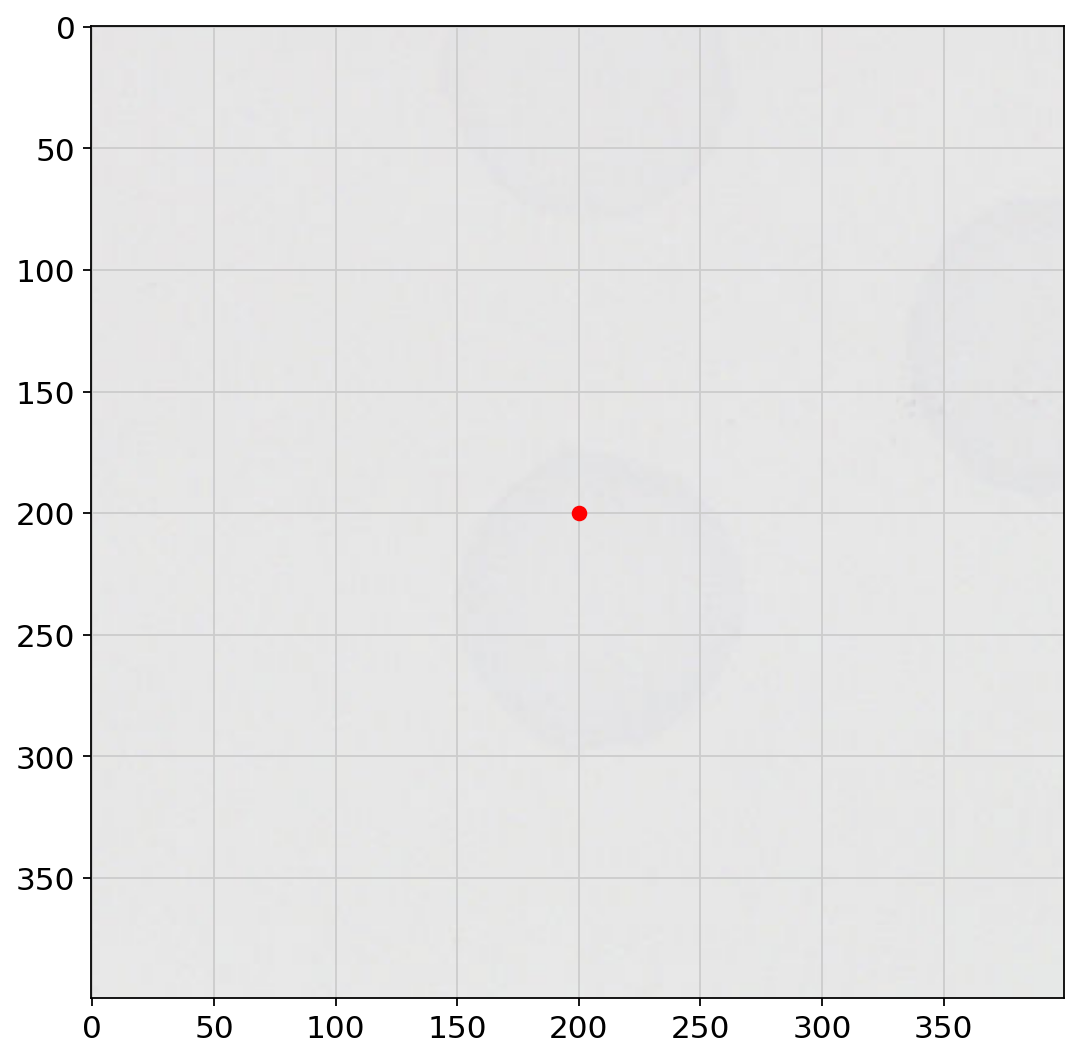

In [25]:
x, y = 16718 , 2813
show_img_patch(img, x, y, patch_size=400, figsize=(8, 8))

2820 2190


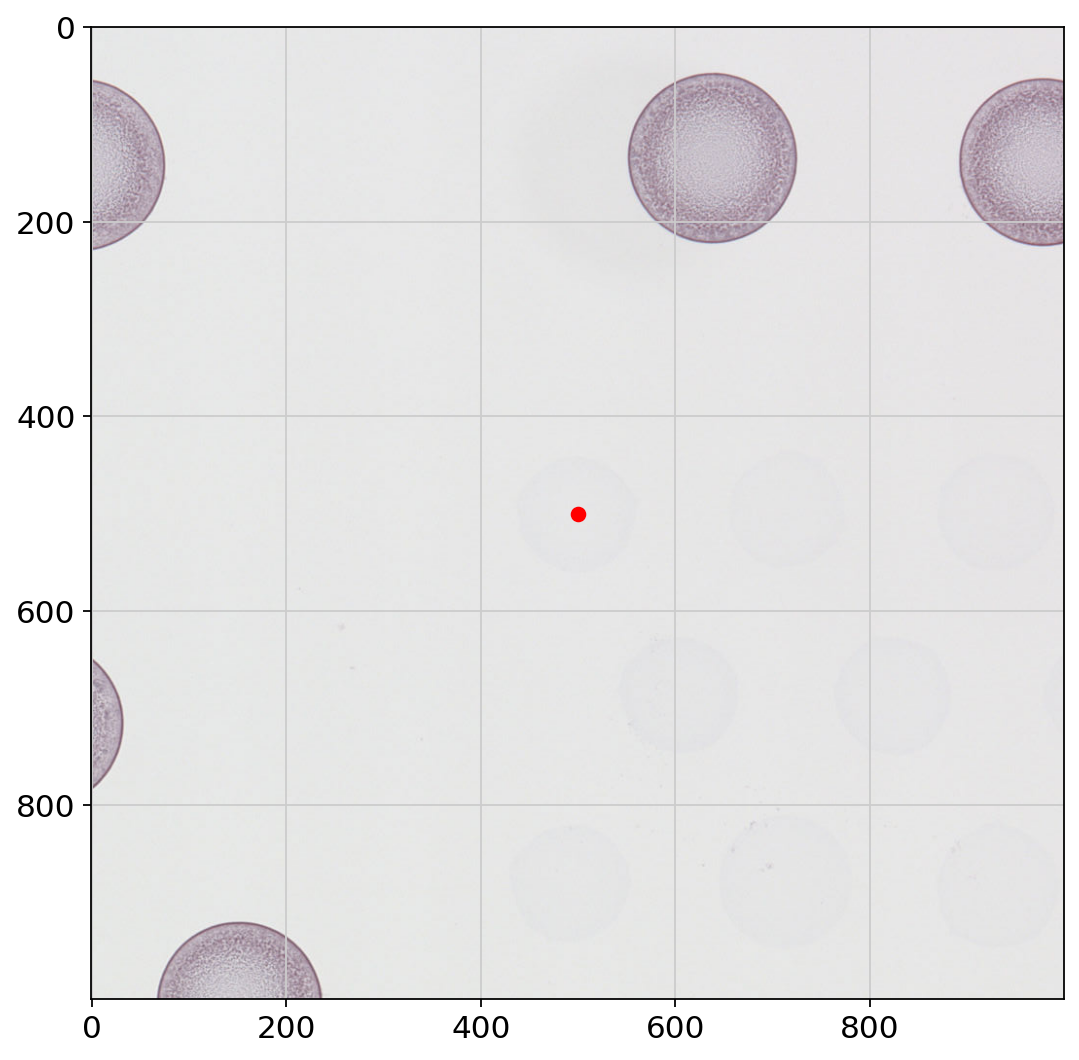

In [70]:
x, y = get_correct_pixel_coord_of_spot(0, 0, df_spatial)
print(x, y)
show_img_patch(rotated_image, x, y, patch_size=1000, figsize=(8, 8))

2820 2630


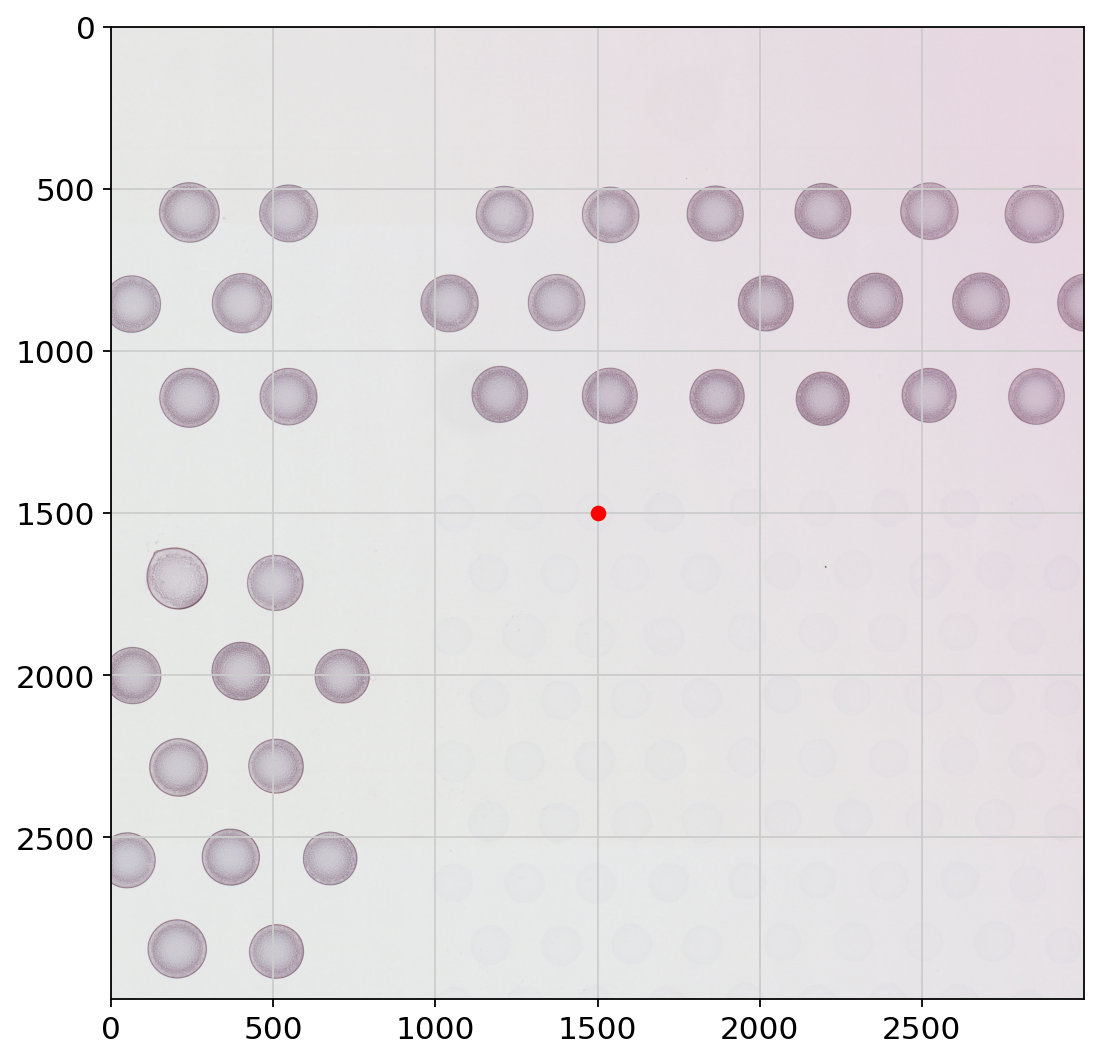

In [55]:
x, y = get_correct_pixel_coord_of_spot(0, 4, df_spatial)
print(x, y)
show_img_patch(rotated_image, x, y, patch_size=3000, figsize=(8, 8))

2820 3508


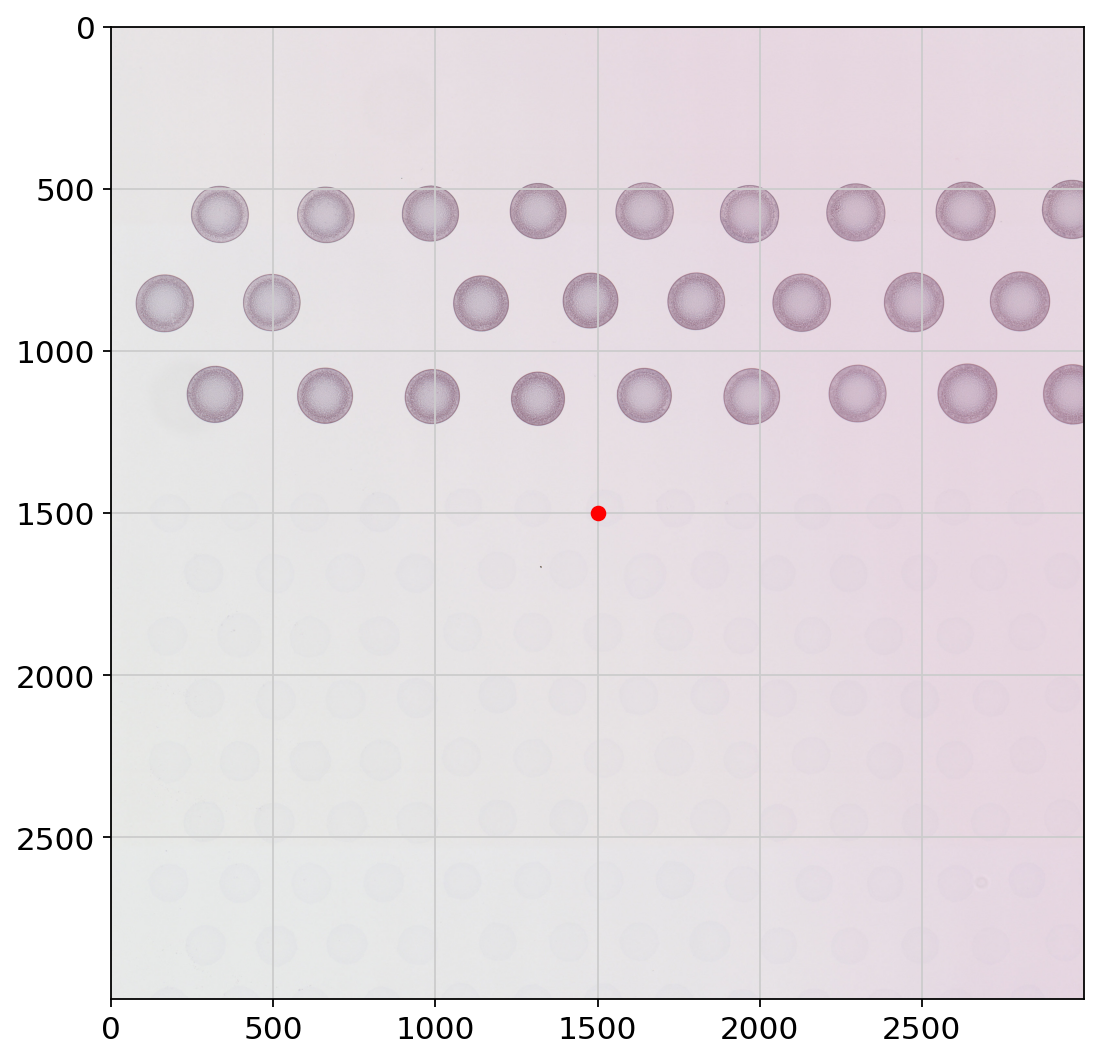

In [54]:
x, y = get_correct_pixel_coord_of_spot(0, 12, df_spatial)
print(x, y)
show_img_patch(rotated_image, x, y, patch_size=3000, figsize=(8, 8))

17446 16129


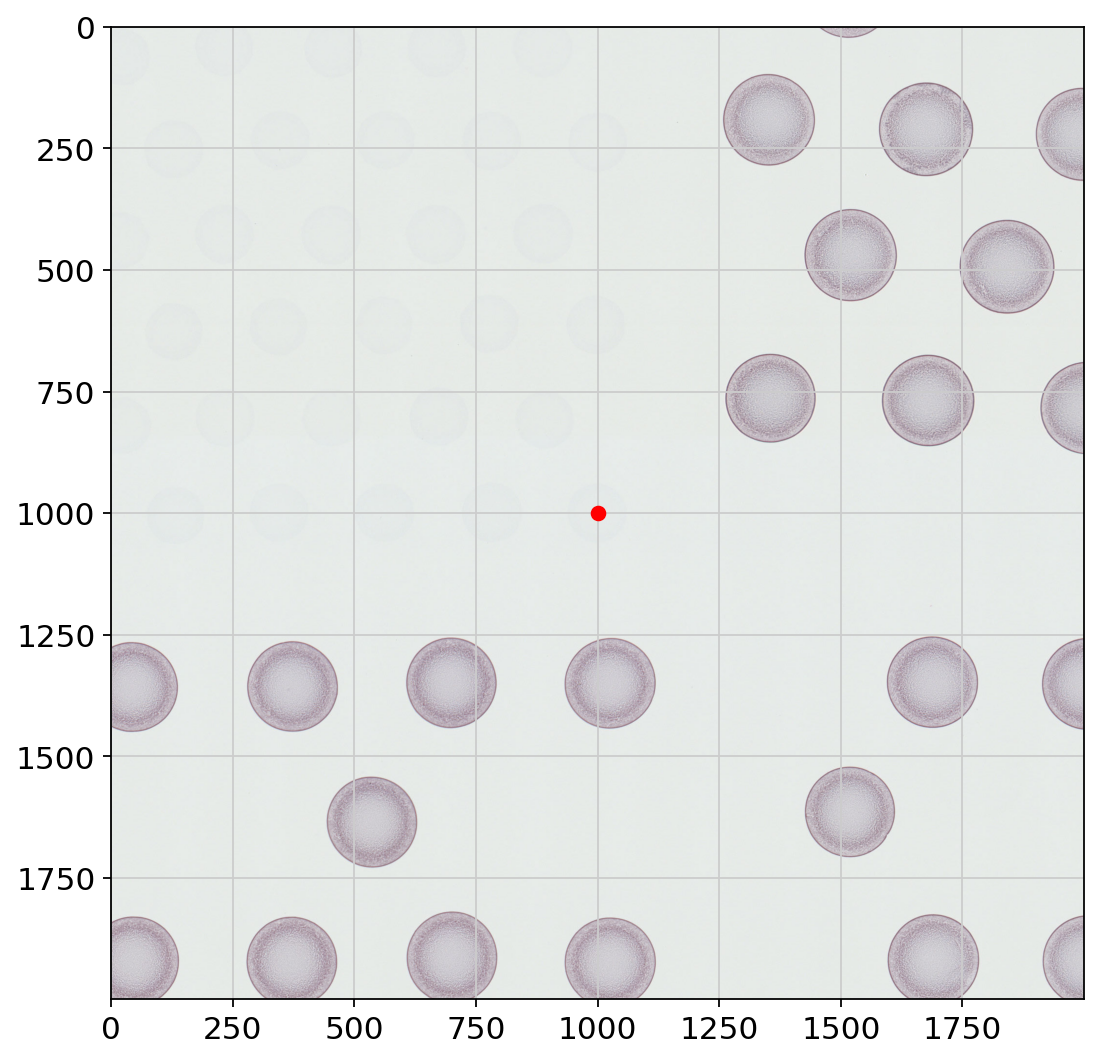

In [69]:
x, y = get_correct_pixel_coord_of_spot(77, 127, df_spatial)
print(x, y)
show_img_patch(rotated_image, x, y, patch_size=2000, figsize=(8, 8))

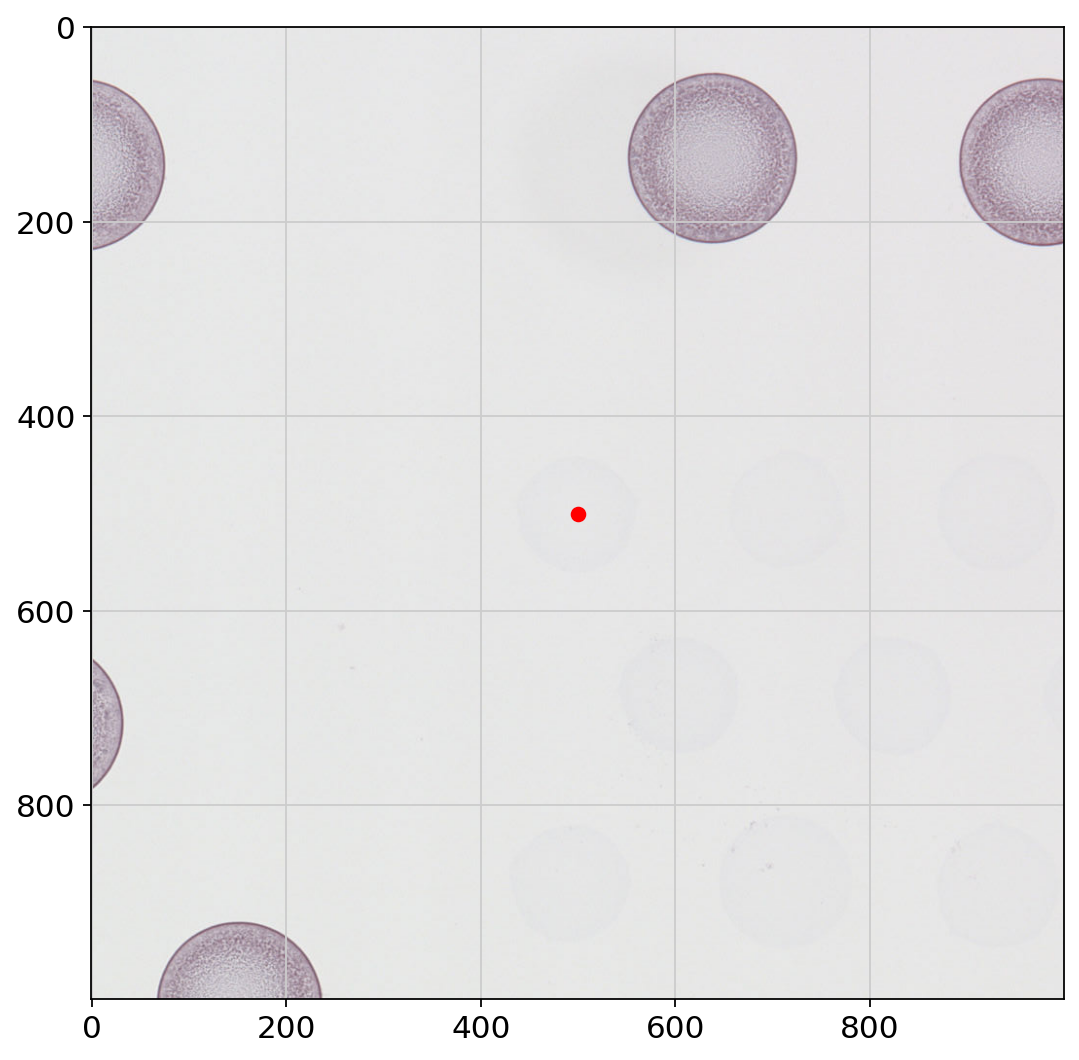

In [37]:
x, y = 2820, 2190
show_img_patch(rotated_image, x, y, patch_size=1000, figsize=(8, 8))

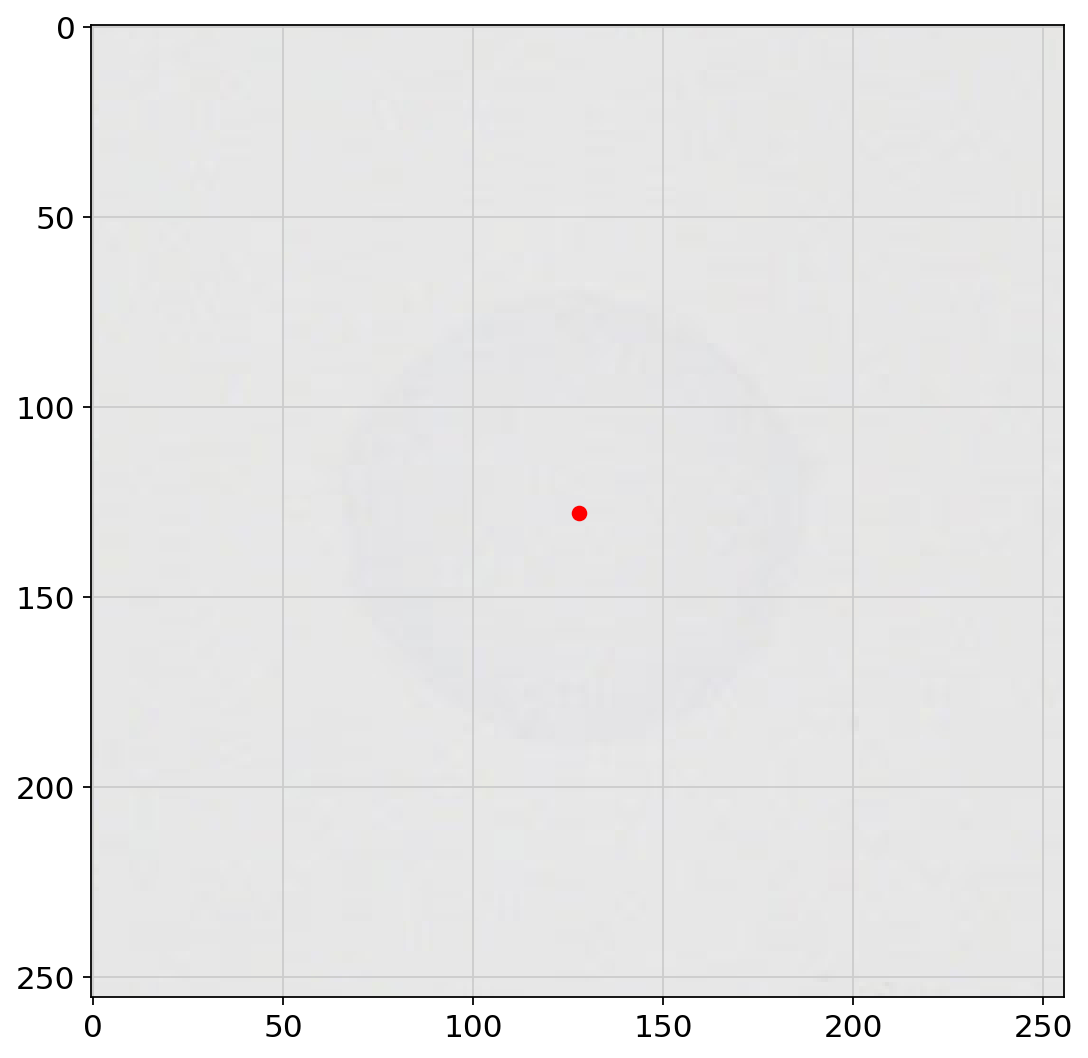

In [38]:
x, y = 2820, 2190
show_img_patch(rotated_image, x, y, patch_size=256, figsize=(8, 8))